## Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from keras.datasets import mnist

## Importing the Dataset

We have imported the MNIST dataset from keras module. The training dataset consists of 60,000 images (that are in the form of 28x28 pixels) and the testing dataset consists of 10,000 images. We then flatten the images such that each image is of the form of a 784 pixel row vector. We then normalise the data using Standard Scaler() function.

In [2]:
#Reading the data from CSV file
(X, Y), (X_test, Y_test) = mnist.load_data()
print("The shape of the training data is: {}".format(X.shape))
print("The shape of the testing data is: {}".format(X_test.shape))

11501568/11490434 [==============================] - 0s 0us/step
The shape of the training data is: (60000, 28, 28)
The shape of the testing data is: (10000, 28, 28)


In [3]:
# flattening the image into row vector
X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [5]:
total_classes = len(np.unique(Y))
print("=== TOTAL NUMBER OF CLASSES IN WHICH EACH IMAGE CAN BE DIVIDED INTO: {} ===".format(10))

=== TOTAL NUMBER OF CLASSES IN WHICH EACH IMAGE CAN BE DIVIDED INTO: 10 ===


## Training the Bayes Classifier on the training dataset

First, for every class (ranging from [1, K]), we compute the following values:

$$ \pi_k = \text{prior probability for every class k} $$
$$ \mu_{kd} = \text{Mean of every pixel d for every class k} $$
$$ \sum_k = \text{Covariance Matrix of every class k with dimensions = }dxd $$

where,
$$ d \in [1, 784] $$
$$ k \in [0, 9] $$

In [6]:
def fit(X, Y):
    n_samples, n_features = X.shape
    classes = np.unique(Y)
    n_classes = len(classes)

    # calculating mean, var, and prior for each class ranging from [0, 9]
    # for every class, calculating the mean for each pixel (ranging from [1, 784]) that belong to that class
    mean = np.zeros((n_classes, n_features), dtype = np.float128)
    # for every class, calculating a covariance matrix (dimension = 784x784)
    variance = np.zeros((n_classes, n_features, n_features), dtype = np.float128)
    # for every class, calculating the probability that an image belongs to that class
    prior_probability = np.zeros(n_classes, dtype = np.float128)
    
    for class_no in range(0, n_classes):
        X_class_c = X[Y == class_no]
        mean[class_no, :] = X_class_c.mean(axis=0)
        variance[class_no, :] = np.cov(X_class_c.T)
        prior_probability[class_no] = X_class_c.shape[0] / n_samples

    return classes, mean, variance, prior_probability

classes, mean, variance, prior_probability = fit(X,Y)

## Predicting the results on the test dataset

We feed in the entire testing dataset (dimensions = Nx784) to the **predict_class()** function. We store the posterior in a matrix of dimension KxN where each row corresponds to a particular class and each column corresponds to an image in the testing data.

The posterior that an image belongs to a particular class is as follows:

$$ P(class = k | X) = \frac{ \pi_k * P(X | class = k)}{P(X)} $$

As the class conditional densities are a Multivariate Gaussian distribution, hence, they can be written as:

$$ P(X | class = k) = \frac{e^{\frac{-1}{2}(X-\mu)*\sum^{-1}*(X-\mu)^T}}{{2\pi}^{D/2}|\sum|^{1/2}} $$

In order to simplify the calculation, we have not considered the denominator in the above term (as it remains the same for every case). Thus the formula now becomes:

$$ P(class = k | X) \propto \pi_k * P(X | class = k) $$

Thus, for an image $X_i$, the final predicted class can be found out as follows:

$$ \text{predicted class} = \underset{a}{\operatorname{\arg max}} (\pi_k * P(X_i | class = k)) $$

In order to simplify the calculation, we take the $\log$ of the above expression which results in the following:

$$ \text{predicted class} = \underset{a}{\operatorname{\arg max}} (\log(\pi_k) + \log(P(X | class = k))) $$

There were some cases where the Covariance Matrix comes out to be a singular matrix. In those situations, we added some noise to the diagonal of the Covariance Matrix such that it does not remain singular anymore.

In [10]:
#Function to calculate the weight (log likelihood) of current class given the point is x
def predict_class(images):
    
    total_images = images.shape[0]
    posterior_each_class = np.zeros((total_classes, total_images), dtype = np.longfloat)
    
    for class_no in range(0, total_classes):
        # computing the predicted class using argmax(c) over log likelihood of (P(x|c)*P(c)) 
        mean_curr_class = mean[class_no]
        cov_matrix_curr_class = variance[class_no]
        prior_curr_class = prior_probability[class_no]
        # storing the predicted probability for all images for a particular class
        posterior_curr_class = multivariate_normal.logpdf(images, mean = mean_curr_class, cov = cov_matrix_curr_class+1e-2*np.eye(cov_matrix_curr_class.shape[0])) + np.log(prior_curr_class)
        posterior_each_class[class_no] = posterior_curr_class
    
    
    posterior_per_image_per_class = posterior_each_class.T
    predicted_classes = []
    for image_no in range(0, total_images):
        max_prob_class = np.argmax(posterior_per_image_per_class[image_no])
        predicted_classes.append(max_prob_class)

    return predicted_classes

In [11]:
predicted_labels = predict_class(X_test)
true_labels = Y_test

count_correct_prediction = 0.0
for i in range(len(predicted_labels)):
    if predicted_labels[i] == true_labels[i]:
        count_correct_prediction += 1.0

accuracy = count_correct_prediction/(len(predicted_labels)*1.0)
print("=== ACCURACY OF THE MODEL: {} ===".format(accuracy*100))

=== ACCURACY OF THE MODEL: 81.53 ===


In [12]:
confusionMatrix = confusion_matrix(true_labels, predicted_labels)
print(confusionMatrix)

[[ 936    0    5   11    1    6    5    1   15    0]
 [   1 1098    7    5    1    0    6    0   16    1]
 [  39    4  781   49    8    1   15    2  130    3]
 [  27    2    8  721    2   10    0    5  216   19]
 [   4    3   18    4  791    2    5    5   29  121]
 [  28    0    3   36    2  560   13    3  234   13]
 [  17    3    4    1    4   12  885    0   32    0]
 [   1    6   11   11   26    0    0  573   31  369]
 [  17   16   10   13    3   14    4    6  878   13]
 [   9    6    4    8   10    0    0   16   26  930]]


Text(0.5, 1.0, 'Confusion Matrix')

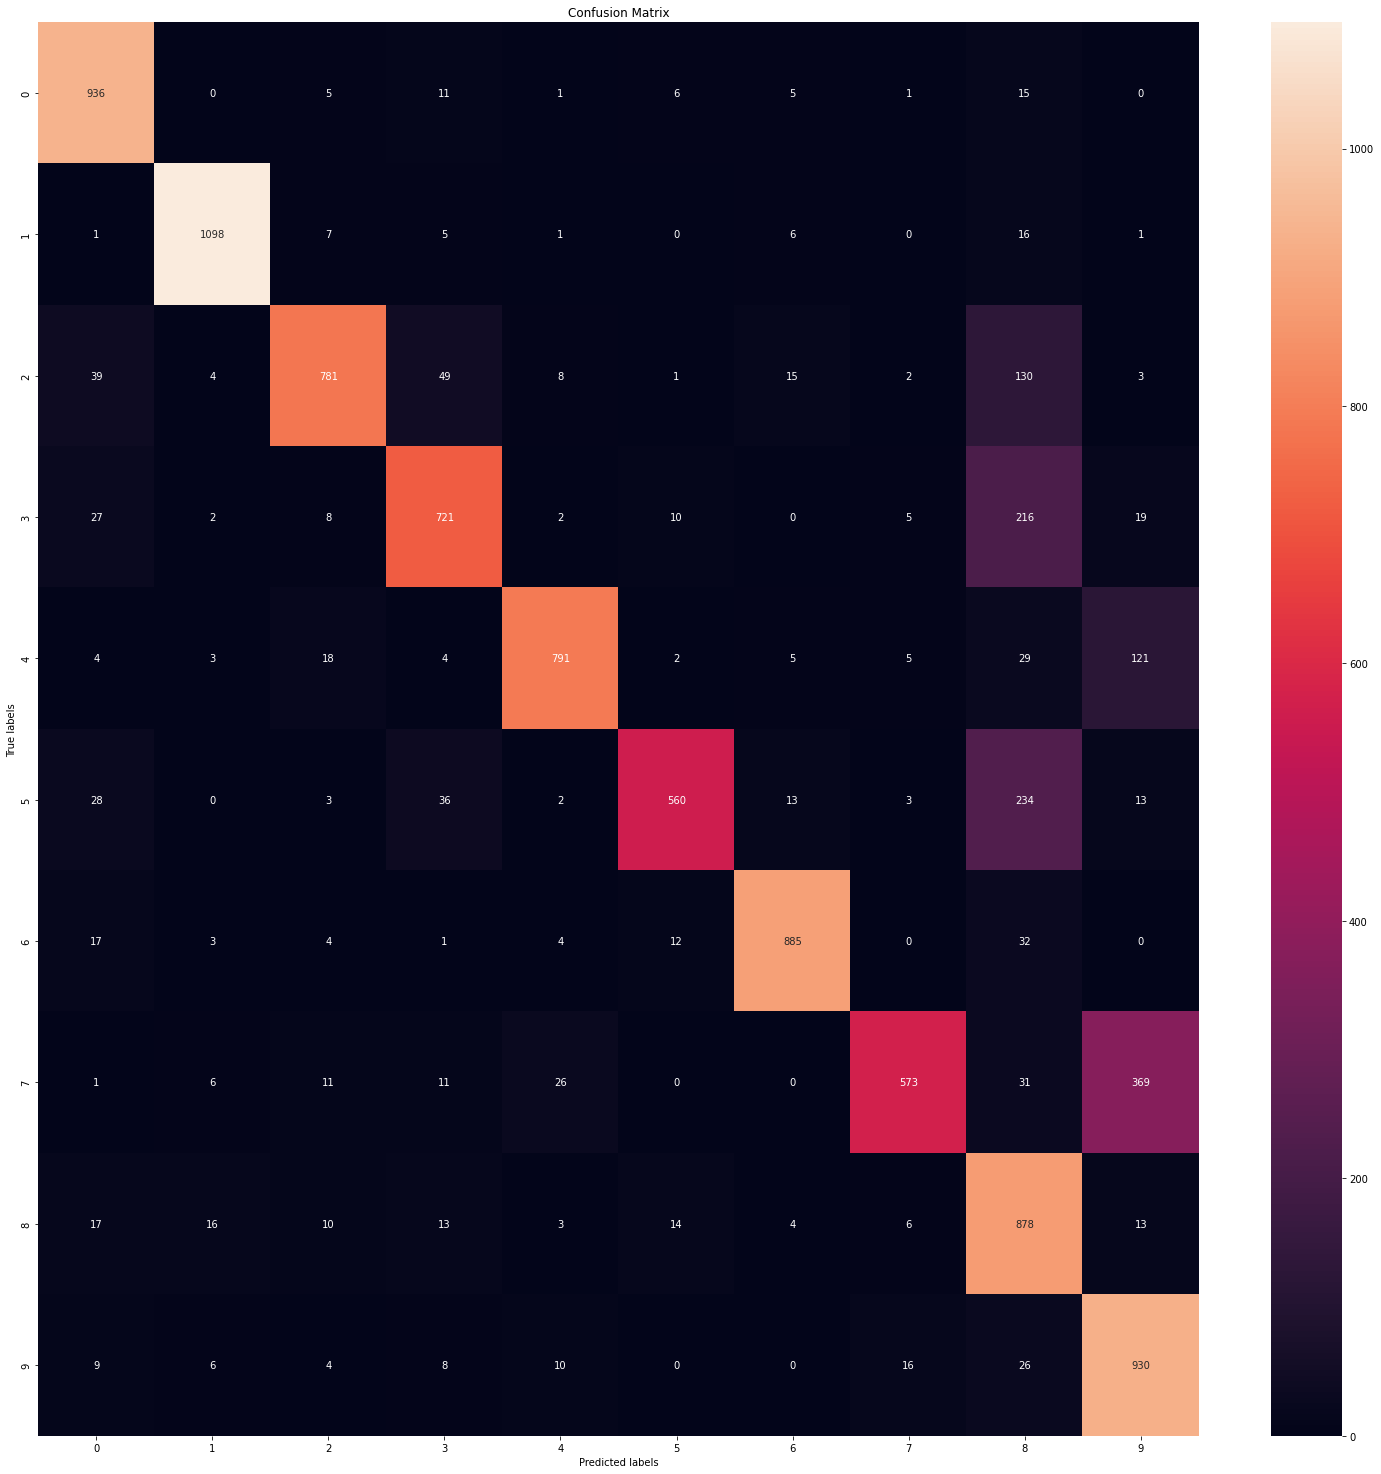

In [13]:
ax = plt.subplots(figsize=(26,26))
ax = sns.heatmap(confusionMatrix, annot=True, fmt='g');  
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')